# 1. Configuration

### Imports

In [41]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import random
import math

### Read the data

In [42]:
dataset = pd.read_csv("dataset.csv")
dataset

,Equation,Xs,Ys
0,((x ** 4) - 6),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-5, 10, 75, 250, 619, 1290, 2395, 4090, 6555,..."
1,(((x / 8) * 2) + 1),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3..."
2,(((x - 1) - 3) / 5),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1...."
3,(x * 5),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
4,(x + 2),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
...,...,...,...
93,1*x**5 + -2*x**3 + -1*x + -5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-7, 9, 181, 887, 2865, 7333, 16109, 31731, 57..."
94,3*x**5 + 2*x**4 + 1*x + -2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4, 128, 892, 3586, 10628, 25924, 55228, 10650..."
95,-4*x**5 + -1*x + -5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-10, -135, -980, -4105, -12510, -31115, -6724..."
96,4*x + +1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49,..."


# 2. Representation

### Tree data structure

#### Node class

In [43]:
class Node:
    def __init__(self, value=None):
        self.value = value
        self.children = []

    def add_child(self, child):
        self.children.append(child)

#### Equation tree class

The `EquationTree` class is a custom implementation of a binary tree data structure that represents a mathematical equation. It is used to parse and evaluate mathematical expressions in a tree-like structure. 

The class has the following methods:

- `build_tree(self, expression)`: Builds the tree structure from a given mathematical expression.
- `print_tree(self)`: Prints the tree structure in a readable format.
- `evaluate(self, x)`: Evaluates the mathematical expression represented by the tree structure for a given value of `x`.


In [44]:
class EquationTree:
    def __init__(self, root=None):
        self.root = root

    def build_tree(self, expression):
        self.root = self._build_tree_recursive(expression)

    def print_tree(self):
        self._print_tree_recursive(self.root)
    
    def evaluate(self, x):
        return self._evaluate_recursive(self.root, x)
     
    def get_array(self):
        return self._get_array_recursive(self.root)

    def replance_random_subtree(self, new_subtree):
        if self.root is None or self.root.children == []:
            self.root = new_subtree.root
        else:
            self._replace_random_subtree_recursive(self.root.children[random.randint(0, 1)], new_subtree.root)
    
    def get_random_subtree(self):
        if self.root is None:
            return None
        return self._get_random_subtree_recursive(self.root)

#recursive functions
        
    def _get_array_recursive(self, root):
        if root is None:
            return []

        array = []

        # If the node has grandchildren, surround the value with parentheses
        if root.children:
            array.append("(")

        if root.children:
            array += self._get_array_recursive(root.children[0])

        # Add the value of the root node
        array.append(root.value)

        # Add the right child recursively
        if root.children and len(root.children) > 1:
            array += self._get_array_recursive(root.children[1])

        # If the node has children, close the parentheses
        if root.children:
            array.append(")")

        return array

    def _get_random_subtree_recursive(self, current_node):
        if not current_node.children:
            return EquationTree(current_node) 

        if random.choice([True, False]):
            return self._get_random_subtree_recursive(random.choice(current_node.children))
        else:
            return EquationTree(current_node)

    def _replace_random_subtree_recursive(self, current_node, new_subtree_root):
        if not current_node.children:
            current_node.value = new_subtree_root.value
            current_node.children = new_subtree_root.children
            return

        if random.choice([True, False]):
            self._replace_random_subtree_recursive(random.choice(current_node.children), new_subtree_root)
        else:
            current_node.value = new_subtree_root.value
            current_node.children = new_subtree_root.children

    def _evaluate_recursive(self, root, x):
        if root is None:
            return None

        if root.value == 'x':
            return x
        elif root.value.lstrip('-').isdigit():
            return int(root.value)
        elif root.value == '+':
            return self._evaluate_recursive(root.children[0], x) + self._evaluate_recursive(root.children[1], x)
        elif root.value == '-':
            return self._evaluate_recursive(root.children[0], x) - self._evaluate_recursive(root.children[1], x)
        elif root.value == '*':
            return self._evaluate_recursive(root.children[0], x) * self._evaluate_recursive(root.children[1], x)
        elif root.value == '/':
            return self._evaluate_recursive(root.children[0], x) / self._evaluate_recursive(root.children[1], x)
        elif root.value == '**':
            return self._evaluate_recursive(root.children[0], x) ** self._evaluate_recursive(root.children[1], x)
        else:
            return None
       
    def _print_tree_recursive(self, root, depth=0):
        if root is None:
            return

        print('\t' * depth + str(root.value) + "--------")

        for child in root.children:
            self._print_tree_recursive(child, depth + 1)

    def _build_tree_recursive(self, expression):
        
        current_depth = -1  #odvisn v kok ( gres notr

        lowest_depth = 0    #najvecja globina
        lowest_depth_index = -1 #index najvecje globine, oz tm k je element d splitamo drevo

        leaf = False    #ce je list pa v izrazu ni vec operatorjev pol vrne list
        leaf_value = None   #vrednost lista

        priority_lvl = 0   #to je zto d ma ** prednost pred * in /, pa + in - pred tem

        for i in range(len(expression)):
            if expression[i] == '(':    
                current_depth += 1  #povecamo globino
            elif expression[i] == ')':
                current_depth -= 1  #zmanjsamo globino
            elif expression[i] in ['+', '-']:
                #   ce smo v najmajsi globini    ce sploh ni globine v enacbi    prednost pred drugimi operatorji (kle nima tok veze, bl je spodi)
                if current_depth < lowest_depth or lowest_depth_index == -1 or priority_lvl > 1:  
                    lowest_depth = current_depth
                    lowest_depth_index = i
                    priority_lvl = 1 
            elif expression[i] in ['*', '/']:
                if current_depth < lowest_depth or lowest_depth_index == -1 or priority_lvl > 2:
                    lowest_depth = current_depth
                    lowest_depth_index = i
                    priority_lvl = 2
            elif expression[i] in ['**']:
                if current_depth < lowest_depth or lowest_depth_index == -1 or priority_lvl > 3:
                    lowest_depth = current_depth
                    lowest_depth_index = i
                    priority_lvl = 3
            elif expression[i] == 'x' or expression[i].lstrip('-').isdigit():
                leaf_value = expression[i]
                leaf = True

        if lowest_depth_index == -1 and leaf:
            return Node(leaf_value)
        else:
            root = Node(expression[lowest_depth_index])
            # print(expression[:lowest_depth_index])
            # print(expression[lowest_depth_index+1:])
            root.add_child(self._build_tree_recursive(expression[:lowest_depth_index])) #rekurzivno zgradimo levo poddrevo
            root.add_child(self._build_tree_recursive(expression[lowest_depth_index+1:]))   #rekurzivno zgradimo desno poddrevo

            return root
        

#### Helper functions

Helper function to convert a string equation into an array of `tokens`.

In [45]:
def stringEQtoArray(equation):
    arr = np.array([])
    skip = 0

    for index, char in enumerate(equation):
        if skip != 0:
            skip-=1
            continue
    
        if char == ' ':
            continue
        elif char == 'x' or char.isdigit():
            arr = np.append(arr, char)
        elif char == '*' and equation[index+1] == '*':
            arr = np.append(arr, '**')
            skip = 1
        elif char in ['+', '-'] and equation[index+1].isdigit():
            if char == '+':
                arr = np.append(arr, equation[index+1])
            else:
                arr = np.append(arr, char+equation[index+1])
            skip = 1
        elif char in ['+', '-', '*', '/', '(', ')']:
            arr = np.append(arr, char)

    return arr

Helper function to convert a string sequance array to an array.

In [46]:
def stringArrayToArray(string):
    string = string[1:-1]
    arr = string.split(',')
    arr = [float(i) for i in arr]
    return arr

In [47]:
#vse dela prou :)

for x in range(0,0):
    equation_inputs = dataset.iloc[x].values[0]
    #print(equation_inputs)
    equation = stringEQtoArray(equation_inputs)
    print(equation)
    equation_tree = EquationTree()
    equation_tree.build_tree(equation) 
    equation_tree.print_tree()

    subtree = equation_tree.get_random_subtree()
    print(subtree.get_array())
    subtree.print_tree()

    equation_tree.replance_random_subtree(subtree)
    print(equation_tree.get_array())

    outputs = stringArrayToArray(dataset.iloc[x].values[2])
    sum = 0
    for i in range(100):
        sum += (equation_tree.evaluate(i+1) - outputs[i])

    #print(sum) #more bit 0
    

In [48]:
def is_valid(solution):

    #if there is no x in the equation -> it is not valid
    if 'x' not in solution:
        return False
    
    if solution.__len__() > 25:
        return False

    try:
        equation_tree = EquationTree()
        equation_tree.build_tree(solution) 
        for i in range(100):
            equation_tree.evaluate(i+1)
    except:
        return False

    for i in range(len(solution)):
        #if there is a x ** x -> it goes to infinity and is not good...
        if solution[i] == 'x' and i+2 < len(solution):
            if solution[i+1] == '**' and solution[i+2] == 'x':
                return False
    
    

    return True

In [160]:
def simplify_equation(equation):
    
    simplified = False
 
    while not simplified:
        remove = False
        #remove () if they are on the start and end of the equation and if there is no operator in the first lvl of ()
        if equation[0] == '(' and equation[-1] == ')':
            remove = True
        lvl = 0 

        for i in range(len(equation)):

            if equation[i] == '(':
                lvl += 1
            if equation[i] == ')':
                lvl -= 1
            if lvl == 0 and equation[i] in ['+','-','*','/','**']:
                remove = False


            if i+1 < len(equation):
                #x**1 = x, x*1 = x, x/1 = x
                if equation[i] in ['**','*','/'] and equation[i+1] == '1':
                    equation[i] = ''
                    equation[i+1] = ''

            if equation[i] == 'x' and i+2 < len(equation):
                
                # x/x = 1
                if equation[i+1] == '/' and equation[i+2] == 'x':
                    equation[i] = '1'
                    equation[i+1] = ''
                    equation[i+2] = ''

            # (x) = x, (1) = 1,...
            elif equation[i] == '(' and i+2 < len(equation):
                if equation[i+2] == ')':
                    equation[i] = ''
                    equation[i+2] = ''

            elif (equation[i].isdigit() or equation[i][1:].isdigit()) and i+2 < len(equation):
                if equation[i+2].isdigit() or equation[i+2][1:].isdigit():
                    if equation[i+1] == '+':
                        equation[i] = str(int(equation[i]) + int(equation[i+2]))
                        equation[i+1] = ''
                        equation[i+2] = ''
                    elif equation[i+1] == '-':
                        equation[i] = str(int(equation[i]) - int(equation[i+2]))
                        equation[i+1] = ''
                        equation[i+2] = ''
                    elif equation[i+1] == '*':
                        equation[i] = str(int(equation[i]) * int(equation[i+2]))
                        equation[i+1] = ''
                        equation[i+2] = ''
                    elif equation[i+1] == '/':
                        equation[i] = str(int(equation[i]) / int(equation[i+2]))
                        equation[i+1] = ''
                        equation[i+2] = ''
                    elif equation[i+1] == '**':
                        equation[i] = str(int(equation[i]) ** int(equation[i+2]))
                        equation[i+1] = ''
                        equation[i+2] = ''

                
        if remove: 
            equation = equation[1:-1]
            
                        
        #remove empty strings
        if '' in equation:
            equation = list(filter(None, equation))
        else:
            simplified = True
            equation = list(filter(None, equation))
            
    return equation    

In [166]:
simplify_equation(['(','x','+','1',')','**','1'])

['x', '+', '1']

In [51]:
#transform a array of chars to a int array
def char_to_int_array(array):
    new_array = []
    for i in array:
        if i == 'x':
            new_array.append(ord(i))
        elif i == '+':
            new_array.append(ord(i))
        elif i == '-':
            new_array.append(ord(i))
        elif i == '*':
            new_array.append(ord(i))
        elif i == '/':
            new_array.append(ord(i))
        elif i == '**':
            new_array.append(420)
        elif i == '(':
            new_array.append(ord(i))
        elif i == ')':
            new_array.append(ord(i))
        else:
            new_array.append(int(float(i)))
    return new_array

#transform a int array to a array of chars
def int_array_to_char(array):
    new_array = []
    for i in array:
        if i == ord('x'):
            new_array.append('x')
        elif i == ord('+'):
            new_array.append('+')
        elif i == ord('-'):
            new_array.append('-')
        elif i == ord('*'):
            new_array.append('*')
        elif i == ord('/'):
            new_array.append('/')
        elif i == 420:
            new_array.append('**')
        elif i == ord('('):
            new_array.append('(')
        elif i == ord(')'):
            new_array.append(')')
        else:
            new_array.append(str(i))
    return new_array

print(char_to_int_array(['x', '+', '-0']))
print(int_array_to_char([120, 43, -0]))


[120, 43, 0]
['x', '+', '0']


In [52]:
# Transform the int array from size n to fixed size of "size" by adding 0 to the end of the array
def transform_array(array, size):
    new_array = np.zeros(size)
    for i in range(len(array)):
        new_array[i] = array[i]
    return new_array

# Inverse
def inverse_transform_array(array):
    new_array = []
    for i in array:
        if i == 0:
            break
        new_array.append(int(i))
    return new_array


print(transform_array(char_to_int_array(['x', '+', '1']), 10))
print(inverse_transform_array(transform_array(char_to_int_array(['x', '+', '1']), 10)))

[120.  43.   1.   0.   0.   0.   0.   0.   0.   0.]
[120, 43, 1]


In [53]:
# put the functions together
def equation_for_GA(equation):
    equation = char_to_int_array(equation)
    equation = transform_array(equation, 25)
    return equation

def equation_from_GA(equation):
    equation = inverse_transform_array(equation)
    equation = int_array_to_char(equation)
    return equation

print(equation_for_GA(['x', '+', '1']))
print(equation_from_GA(equation_for_GA(['x', '+', '1'])))

[120.  43.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
['x', '+', '1']


### 3. Genetic algorithm

In [54]:
#trying for the first equation first
eq_num = 2

true_equation = stringEQtoArray(dataset.iloc[eq_num].values[0])
inputs = stringArrayToArray(dataset.iloc[eq_num].values[1])
outputs = np.array(stringArrayToArray(dataset.iloc[eq_num].values[2]))

print(true_equation)
print(inputs)
print(outputs)

['(' '(' '(' 'x' '-' '1' ')' '-' '3' ')' '/' '5' ')']
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]
[-0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.
  2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8
  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2

In [55]:
def model(equation):
    print("Starting model")
    if not is_valid(equation_from_GA(equation)):
        print("Invalid equation")
        return np.zeros(100),0

    equation = equation_from_GA(equation)

    print(equation)

    equation_tree = EquationTree()
    equation_tree.build_tree(equation)

    #remove all the () from the equation
    equation = [x for x in equation if x != '(' and x != ')']
    equation = np.array(equation)

    #get the length of the equation
    equation_length = len(equation)
            
    return np.array([equation_tree.evaluate(i+1) for i in range(100)]), equation_length


In [56]:
def fitness_func(ga_instance, solution, solution_idx):
    print("Starting fitness_func")
    model_outputs,equation_length = model(solution)

    model_outputs = np.array(model_outputs)

    # if equation_length >= 3:
    #     error = np.sum(np.abs(model_outputs - outputs)) * (equation_length ** 0.5)
    # else:
    
    try:
        error = np.sum(np.log10(np.abs(model_outputs - outputs) + 1))

        if error < 0:
            error = -error

    except:
        error = np.inf

    #print("Fitness: ", -error, "ga_instance.generation: ", ga_instance.generations_completed, "solution_idx: ", solution_idx)

    return -error

In [57]:
def crossover_func(parents, offspring_size, ga_instance):
    print("Starting crossover")
    num_of_parents = parents.__len__()
    print(num_of_parents)
    #note : 100 is the length of the equation
    array = np.empty((0, 25))

    for i in range(0,num_of_parents,2):
        #build a parent tree
        parent1_tree = EquationTree()
        print(equation_from_GA(parents[i]))
        parent1_tree.build_tree(equation_from_GA(parents[i]))

        parent2_tree = EquationTree()

        print(equation_from_GA(parents[i+1]))
        parent2_tree.build_tree(equation_from_GA(parents[i+1]))

        parent1_subtree = parent1_tree.get_random_subtree()
        parent2_tree.replance_random_subtree(parent1_subtree)
        child = parent2_tree.get_array()
        print("GET ARRAY: ")
        print(child)
        child = simplify_equation(child)
        print(child)

        if not is_valid(child):
            print("NOT VALID")
            child = parents[i]

        child = equation_for_GA(child)
        #add the child array to the array
        child_array = np.array(child, dtype=int).reshape(1, -1)
        array = np.vstack((array, child_array))

    # print("Crossover: ")
    # for i in array:
    #     print(equation_from_GA(i))

    print(ga_instance.generations_completed, ga_instance.population.__len__())
    for i in ga_instance.population:
        print(equation_from_GA(i) , fitness_func(ga_instance, i, 0))

    return array

In [58]:
def mutation_func(offspring, ga_instance):
    print("Starting mutation")
    array = np.empty((0, 25))

    for j in range(len(offspring)):
        eq_mutated = equation_from_GA(offspring[j])
        
        while True:
            
            #if there are no operators or numbers in the equation -> it is not valid
            if not any(char.isdigit() for char in eq_mutated) or not any(char in ['+', '-', '*', '/', '**'] for char in eq_mutated):
                break

            i = random.randrange(len(eq_mutated))
            if eq_mutated[i] in ['+', '-', '*', '/', '**']:
                eq_mutated[i] = np.random.choice(['+', '-', '*', '/', '**'])
                break
            elif eq_mutated[i].isdigit():
                random_number = str(np.random.randint(-10, 10))
                if random_number == '0':
                    random_number = '1'
                eq_mutated[i] = random_number
                break
            
        if np.random.rand() > 0.9:
        
            #if it doesnt have () on the start and the end add them
            if eq_mutated[0] != '(' and eq_mutated[-1] != ')':
                eq_mutated = np.append(['('], eq_mutated)
                eq_mutated = np.append(eq_mutated, [')'])

            eq_mutated = np.append(eq_mutated, np.random.choice(['+', '-', '*', '/', '**']))
            random_number = str(np.random.randint(-10, 10))
            if random_number == '0':
                random_number = '1'
            eq_mutated = np.append(eq_mutated, random_number)

        if not is_valid(eq_mutated):
            eq_mutated = equation_from_GA(offspring[j])

        eq_mutated = simplify_equation(eq_mutated)

        offspring_array = np.array(equation_for_GA(eq_mutated), dtype=int).reshape(1, -1)
        array = np.vstack((array, offspring_array))

    # print("Mutation: ")
    # for i in array:
    #     print(equation_from_GA(i))

    return array

In [59]:
pop1 = [['x','+', '1']] + [['x','+', '2']] +[['x','+', '3']] + [['x','+', '4']] + [['x','+', '5']]
pop2 = [['x','*', '1']] + [['x','*', '2']] +[['x','*', '3']] + [['x','*', '4']] + [['x','*', '5']]  
pop3 = [['x','**', '2']] +[['x','**', '3']] + [['x','**', '4']] + [['x','**', '5']] + [['x','**', '6']] +[['x','**', '7']]
pop4 = [['x','/', '2']] +[['x','/', '3']] + [['x','/', '4']] + [['x','/', '5']]

initial_population = pop1 + pop2 + pop3 + pop4

#transform the initial population to a int array
initial_population = [equation_for_GA(i) for i in initial_population]

gene_space = np.array([ord('x'), ord('+'), ord('-'), ord('*'), ord('/'), 420, 1, 2, 3, 4, 5, 6, 7, 8, 9,-1, -2, -3, -4, -5, -6, -7, -8, -9])

In [60]:
sol_per_pop = initial_population.__len__()
num_parents_mating = 10
keep_elitism = int(sol_per_pop - num_parents_mating/2)

print("sol_per_pop: ", sol_per_pop)
print("num_parents_mating: ", num_parents_mating)
print("keep_elitism: ", keep_elitism)

sol_per_pop:  20
num_parents_mating:  10
keep_elitism:  15


In [61]:
def printCrossover(x,y):
    print("Crossover")

def printMutation(x,y):
    print("Mutation")

def printFitness(x,y):
    print("Fitness")

def printParents(y,parents):
    print("Parents: ")
    for i in parents:
        print(equation_from_GA(i))

In [70]:
ga_instance = pygad.GA(num_generations=100,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       initial_population=initial_population,
                       gene_type=int,
                       parent_selection_type="tournament",
                       keep_elitism=keep_elitism,
                       crossover_probability=0.8,
                       crossover_type=crossover_func,
                       mutation_type=mutation_func,
                       mutation_probability=0.2,
                       gene_space=gene_space,
                       on_crossover=printCrossover,
                       on_mutation=printMutation,
                       on_fitness=printFitness,
                       on_parents=printParents)


ga_instance.run()


list index out of range
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pygad/pygad.py", line 2020, in run
    self.last_generation_offspring_crossover = self.crossover(self.last_generation_parents,
                                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/r_/0ymw_h356pqcpslcb7w07lfd183tlj/T/ipykernel_95068/210714192.py", line 16, in crossover_func
    parent2_tree.build_tree(equation_from_GA(parents[i+1]))
  File "/var/folders/r_/0ymw_h356pqcpslcb7w07lfd183tlj/T/ipykernel_95068/1665193908.py", line 6, in build_tree
    self.root = self._build_tree_recursive(expression)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/r_/0ymw_h356pqcpslcb7w07lfd183tlj/T/ipykernel_95068/1665193908.py", line 151, in _build_tree_recursive
    root.add_child(self._build_tree_recursive(expression[lowest_depth_index+1:]))   #rekurzivno zgradimo desno pod

Starting fitness_func
Starting model
['x', '+', '1']
Starting fitness_func
Starting model
['x', '+', '2']
Starting fitness_func
Starting model
['x', '+', '3']
Starting fitness_func
Starting model
['x', '+', '4']
Starting fitness_func
Starting model
['x', '+', '5']
Starting fitness_func
Starting model
['x', '*', '1']
Starting fitness_func
Starting model
['x', '*', '2']
Starting fitness_func
Starting model
['x', '*', '3']
Starting fitness_func
Starting model
['x', '*', '4']
Starting fitness_func
Starting model
['x', '*', '5']
Starting fitness_func
Starting model
['x', '**', '2']
Starting fitness_func
Starting model
['x', '**', '3']
Starting fitness_func
Starting model
['x', '**', '4']
Starting fitness_func
Starting model
['x', '**', '5']
Starting fitness_func
Starting model
['x', '**', '6']
Starting fitness_func
Starting model
['x', '**', '7']
Starting fitness_func
Starting model
['x', '/', '2']
Starting fitness_func
Starting model
['x', '/', '3']
Starting fitness_func
Starting model
['x

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [63]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best parameter", equation_from_GA(solution))
print("Fitness", solution_fitness)
print("Index", solution_idx)

Starting fitness_func
Starting model
['(', 'x', '-', '5', ')', '-', '5']
Starting fitness_func
Starting model
['(', '(', 'x', '-', '5', ')', '+', '1', ')', '+', '(', '(', '(', 'x', '-', '5', ')', '+', '1', ')', '/', '5', ')']
Starting fitness_func
Starting model
['(', 'x', '-', '5', ')', '*', '5']
Starting fitness_func
Starting model
['(', 'x', '-', '5', ')', '/', '(', '(', 'x', '-', '5', ')', '-', '5', ')', '*', '4']
Best parameter ['(', 'x', '-', '4', ')', '/', '5']
Fitness -0.0
Index 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


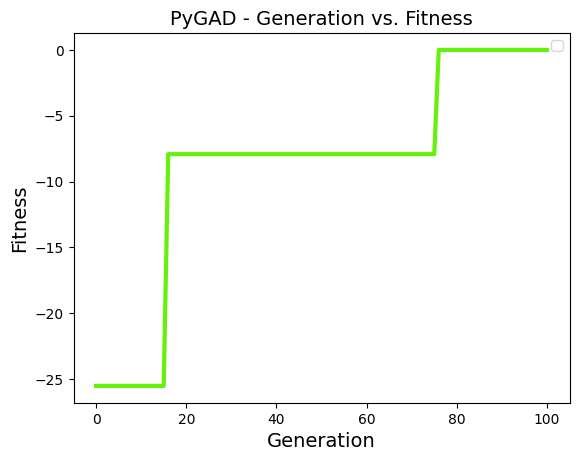

Figure(640x480)


In [64]:
print(ga_instance.plot_fitness())